# Come si comportano le squadre di Serie A sui calci piazzati?
## 2022-23 Giornata 13 [filippo gronchi - dati Opta]
Prendendo spunto dai 2 goal consecutivi (e identici) segnati da Milenkovic su corner di Biraghi e ricordando di una certa inconsistenza della Fiorentina in questo fondamentale ho voluto analizzare il comportamento di tutti i team di Serie A per quel che riguarda i calci da fermo (angoli, punizioni, rigori) sempre più decisivi per sbloccare partite chiuse ed equilibrate.

Osservazioni:<br>
[Fase offensiva]
<ul>
<li>Per quanto riguarda i goal segnati il Napoli stravince anche questa classifica con ben 11 reti. La Roma risulta invece quella che ottiene di più in termini percentuali (oltre 43% dei goal segnati da calci piazzati).</li>
<li>Nelle zone alte di classifica balzano agli occhi i numeri (negativi) di Milan e Lazio con soli 3 goal ognuna da palla ferma. In basso Empoli e Sampdoria hanno segnato 1 solo goal in queste situazioni mentre la Cremonese va in controtendenza con numeri da vera top.</li>
<li>Ragionando invece in termini di Expected Goal proprio la Cremonese di Mister Alvini è quella che crea di più da calci piazzati rispetto a tutta la sua fase offensiva. Ottima prova anche della Fiorentina tanto confermare che le sensazioni visive devono pii essere sempre confermate dai numeri.</li>
</ul><br>
[Fase difensiva]
<ul>
<li>Eclatante il dato negativo della Lazio che risulta davvero carente in fase difensiva sui piazzati (5 goal subiti su 8). Male anche Lecce (8 su 16) e soprattutto Juventus (3 su 7)</li>
<li>In positivo altrettando strano il dato del Verona che su 26 reti subite solo 2 sono venute da palla ferma. In termini difensivi ottima anche la Fiorentina che subisce solo il 17% di xG (al pari del Verona)</li>
</ul>

In [8]:
# Initial environment setup
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from highlight_text import ax_text, fig_text
import pandas as pd

from PIL import Image
import urllib
import os

# --- Use this only if you have already downloaded fonts into your
# --- local directory.

# Add pretty fonts
font_path = r"../assets/fonts" #Set the path to where the fonts are located

for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y)
            except Exception as e:
                print(f"Font {y} could not be added.")
                continue


# --- Reading the data
df = pd.read_csv("../data/SerieA_22_23_match_shots.csv", index_col = 'Ind')


Font DMSans-BoldItalic.ttf could not be added.
Font DMSans-Italic.ttf could not be added.
Font DMSans-MediumItalic.ttf could not be added.
Font Karla-BoldItalic.ttf could not be added.
Font Karla-ExtraBold.ttf could not be added.
Font Karla-ExtraBoldItalic.ttf could not be added.
Font Karla-ExtraLight.ttf could not be added.
Font Karla-ExtraLightItalic.ttf could not be added.
Font Karla-Italic.ttf could not be added.
Font Karla-MediumItalic.ttf could not be added.
Font Karla-SemiBoldItalic.ttf could not be added.


In [9]:
# Preprocessing for Scored Goals
SetPiece = ['FreeKick', 'FromCorner', 'Penalty', 'SetPiece']
df_sp = df.copy()
df_sp['SP'] = df_sp['situation'].isin(SetPiece)
df_sp['GoalSP'] = 0
df_sp.loc[(df_sp['SP']==True) & (df_sp['event_type']=='Goal') & (df_sp['is_own_goal']==False), 'GoalSP'] = 1
df_sp['Goal_no_SP'] = 0
df_sp.loc[((df_sp['SP']==False) & (df_sp['event_type']=='Goal') & (df_sp['is_own_goal']==False)), 'Goal_no_SP'] = 1
df_sp.loc[((df_sp['event_type']=='Goal') & (df_sp['is_own_goal']==True)), 'Goal_no_SP'] = 1

def AssignTeamName(row):
    if (row['is_own_goal']):
        if (row['team_id']==row['home_team_id']):
            return row['away_team']
        else:
            return row['home_team']
    else:
        if (row['team_id']==row['home_team_id']):
            return row['home_team']
        else:
            return row['away_team']

def AssignTeamId(row):
    if (row['is_own_goal']):
        if (row['team_id']==row['home_team_id']):
            return row['away_team_id']
        else:
            return row['home_team_id']
    else:
        if (row['team_id']==row['home_team_id']):
            return row['home_team_id']
        else:
            return row['away_team_id']

df_sp['teamName'] = df_sp.apply(AssignTeamName,1)
df_sp['teamId'] = df_sp.apply(AssignTeamId,1)
df_sp['xG_sp'] = df_sp['expected_goals']*df_sp['SP']
df_sp['xG_no_sp'] = df_sp['expected_goals']* ~df_sp['SP']

Cols = ['event_type', 'teamId', 'teamName', 'xG_sp', 'xG_no_sp', 'situation', 'GoalSP', 'Goal_no_SP', 'SP']
df_sp = df_sp[Cols]
df_final = df_sp.groupby(['teamName', 'teamId']).agg(GoalSPtot=pd.NamedAgg(column='GoalSP', aggfunc='sum'),
            Goal_no_SPtot=pd.NamedAgg(column='Goal_no_SP', aggfunc='sum'),
            xG_sp_tot=pd.NamedAgg(column='xG_sp', aggfunc='sum'),
            xG_no_sp_tot=pd.NamedAgg(column='xG_no_sp', aggfunc='sum')).reset_index()
df_final['GoalSP_share']=df_final['GoalSPtot']/(df_final['GoalSPtot']+df_final['Goal_no_SPtot'])
df_final['xG_sp_share']=df_final['xG_sp_tot']/(df_final['xG_sp_tot']+df_final['xG_no_sp_tot'])
df_final['GoalTot'] = df_final['GoalSPtot']+df_final['Goal_no_SPtot']
df_final['xGTot'] = df_final['xG_sp_tot']+df_final['xG_no_sp_tot']

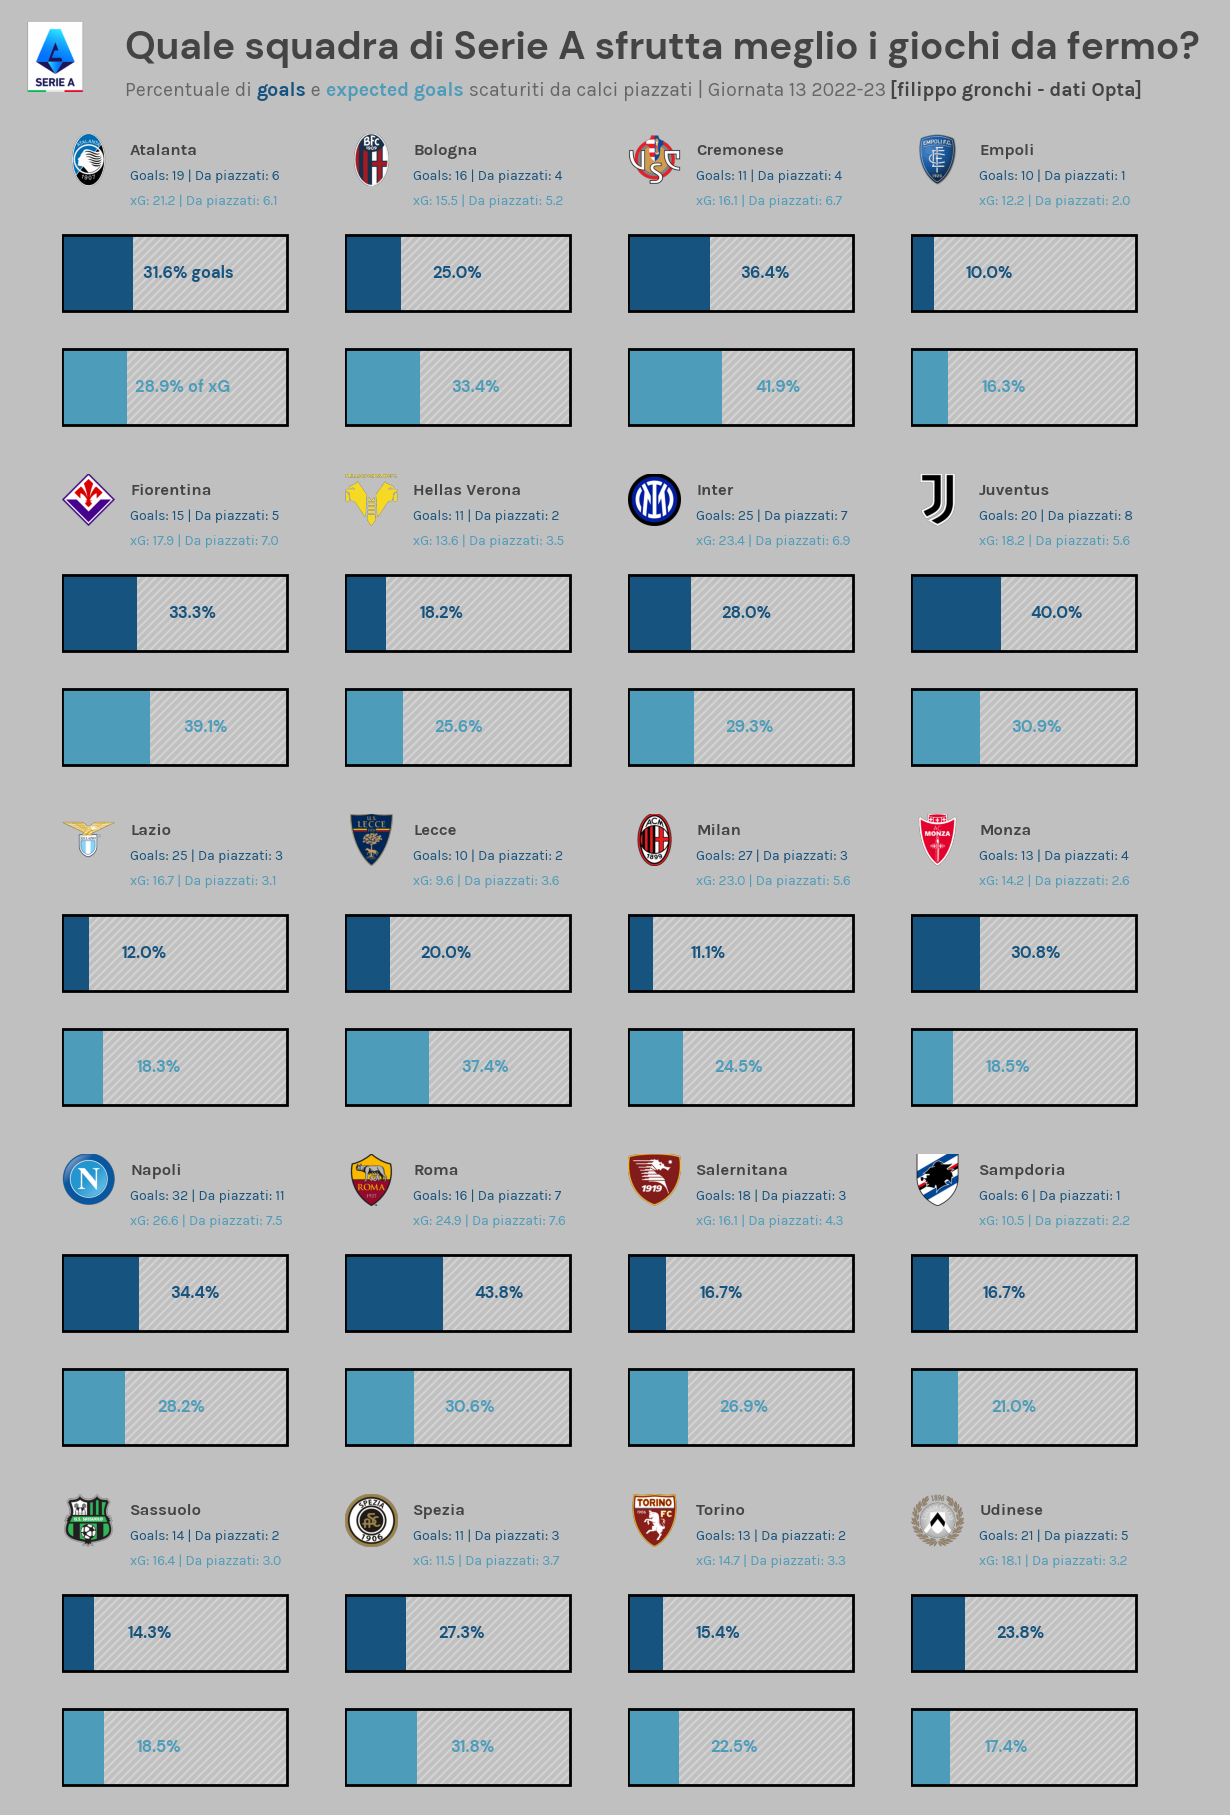

In [10]:
# Scored Gaols and xG
def plot_battery_chart(data, team_id, ax, legend = False):
    '''
    This function plots the share of xG and goals that were created
    from set-pieces and corners in the MLS.

    Args:
        data (DataFrame): the pandas DataFrame with the data.
        team_id (int): the Fotmob team id.
        ax (object): the matplotlib axes in which to draw the plot.
    '''

    goal_share = data[data["teamId"] == team_id]["GoalSP_share"].iloc[0]
    xg_share = data[data["teamId"] == team_id]["xG_sp_share"].iloc[0]

    # Hatch parameters
    plt.rcParams['hatch.linewidth'] = 0.75
    plt.rcParams['hatch.color'] = "lightgrey"

    # Goal share

    if legend:
        goal_text = f"{goal_share:.1%} goals"
        xg_text = f"{xg_share:.1%} of xG"
    else:
        goal_text = f"{goal_share:.1%}"
        xg_text = f"{xg_share:.1%}"      

    height = .1

    ax.barh([1], [1], height = height, facecolor = "none", ec = "black", zorder = 3)
    ax.barh([1], [goal_share], height = height, color = "#16537e")
    ax.barh([1], [1 - goal_share], height = height, left = goal_share, facecolor = "none", hatch="////////")
    ax.annotate(
        xy = (goal_share, 1),
        xytext = (20, 0),
        textcoords = "offset points",
        text = goal_text,
        ha = "center",
        va = "center",
        size = 6,
        weight = "bold",
        family = "DM Sans",
        color = "#16537e"
    )

    ax.barh([.85], [1], height = height, facecolor = "none", ec = "black", zorder = 3)
    ax.barh([.85], [xg_share], height = height, color = "#4d9cba")
    ax.barh([.85], [1 - xg_share], height = height, left = xg_share, facecolor = "none", hatch="////////")
    ax.annotate(
        xy = (xg_share, .85),
        xytext = (20, 0),
        textcoords = "offset points",
        text = xg_text,
        ha = "center",
        va = "center",
        size = 6,
        weight = "bold",
        family = "DM Sans",
        color = "#4d9cba"
    )

    ax.set_axis_off()


# Final chart
fig = plt.figure(figsize=(7, 11), dpi = 200, facecolor="#c0c0c0")
nrows = 10
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios = [(1/nrows)*2. if x % 2 != 0 else (1/nrows)/2. for x in range(nrows)], hspace = 0.3
)

plot_counter = 0
logo_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor = "#c0c0c0"
            )

            if row == 1 and col == 0:
                legend = True
            else:
                legend = False
            
            plot_battery_chart(data = df_final, team_id=df_final["teamId"].iloc[plot_counter], ax = ax, legend = legend)
            plot_counter += 1
        
        else:
            team_id = df_final["teamId"].iloc[logo_counter]
            team_name = df_final["teamName"].iloc[logo_counter]
            goal_set_pieces = df_final[df_final["teamId"] == team_id]["GoalSPtot"].iloc[0]
            xg_set_pieces = df_final[df_final["teamId"] == team_id]["xG_sp_tot"].iloc[0]
            goals_for = df_final[df_final["teamId"] == team_id]["GoalTot"].iloc[0]
            xg_for = df_final[df_final["teamId"] == team_id]["xGTot"].iloc[0]


            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = "NW", facecolor = "#c0c0c0"
            )
            club_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{team_id:.0f}.png"))
            logo_ax.imshow(club_icon)
            logo_ax.axis("off")

            # Add the team name
            ax_text(
                x = 1.3, 
                y = 0.81,
                s = f"{team_name}",
                ax = logo_ax, 
                weight = "bold", 
                font = "Karla", 
                ha = "left", 
                size = 6,
                color="#444444",
                annotationbbox_kw = {"xycoords":"axes fraction"}
            )

            # Add the subtitles for each side
            ax_text(
                x = 1.3,
                y = 0.32,
                s = f"<Goals: {goals_for} | Da piazzati: {goal_set_pieces}>\n<xG: {xg_for:.1f} | Da piazzati: {xg_set_pieces:.1f}>",
                highlight_textprops=[
                    {"color":"#16537e"},
                    {"color":"#4d9cba"}
                ],
                ax = logo_ax, 
                weight = "normal", 
                font = "Karla", 
                ha = "left", 
                size = 5, 
                annotationbbox_kw = {"xycoords":"axes fraction"}
            )
            logo_counter += 1

fig_text(
    x = 0.17, y = .91, 
    s = "Quale squadra di Serie A sfrutta meglio i giochi da fermo?",
    va = "bottom", ha = "left",
    fontsize = 14, color = "#444444", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.17, y = .895, 
    s = "Percentuale di <goals> e <expected goals> scaturiti da calci piazzati | Giornata 13 2022-23 <[filippo gronchi - dati Opta]>",
    highlight_textprops=[
        {"color":"#16537e", "weight":"bold"},
        {"color":"#4d9cba", "weight":"bold"},
        {"color":"#444444", "weight":"bold"}
    ],
	va = "bottom", ha = "left",
	fontsize = 7, color = "#666666", font = "Karla"
)

# # ---- The League's logo
league_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/leaguelogo/55.png"))
league_ax = fig.add_axes([0.095, 0.89, 0.05, 0.05], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")

plt.savefig(
	"../figures/SerieA_22_23_set_piece.png",
	dpi = 500,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)


In [11]:
# Preprocessing for Allowed Goals
SetPiece = ['FreeKick', 'FromCorner', 'Penalty', 'SetPiece']
df_spa = df.copy()
df_spa['SP'] = df_spa['situation'].isin(SetPiece)
df_spa['GoalSP'] = 0
df_spa.loc[(df_spa['SP']==True) & (df_spa['event_type']=='Goal') & (df_spa['is_own_goal']==False), 'GoalSPA'] = 1
df_spa['Goal_no_SP'] = 0
df_spa.loc[((df_spa['SP']==False) & (df_spa['event_type']=='Goal') & (df_spa['is_own_goal']==False)), 'Goal_no_SPA'] = 1
df_spa.loc[((df_spa['event_type']=='Goal') & (df_spa['is_own_goal']==True)), 'Goal_no_SPA'] = 1

def AssignTeamNameA(row):
    if (row['is_own_goal']):
        if (row['team_id']==row['home_team_id']):
            return row['home_team']
        else:
            return row['away_team']
    else:
        if (row['team_id']==row['home_team_id']):
            return row['away_team']
        else:
            return row['home_team']

def AssignTeamIdA(row):
    if (row['is_own_goal']):
        if (row['team_id']==row['home_team_id']):
            return row['home_team_id']
        else:
            return row['away_team_id']
    else:
        if (row['team_id']==row['home_team_id']):
            return row['away_team_id']
        else:
            return row['home_team_id']

df_spa['teamName'] = df_spa.apply(AssignTeamNameA,1)
df_spa['teamId'] = df_spa.apply(AssignTeamIdA,1)
df_spa['xGA_sp'] = df_spa['expected_goals']*df_spa['SP']
df_spa['xGA_no_sp'] = df_spa['expected_goals']* ~df_spa['SP']

Cols = ['event_type', 'teamId', 'teamName', 'xGA_sp', 'xGA_no_sp', 'situation', 'GoalSPA', 'Goal_no_SPA', 'SP']
df_spa = df_spa[Cols]
df_finala = df_spa.groupby(['teamName', 'teamId']).agg(GoalSPAtot=pd.NamedAgg(column='GoalSPA', aggfunc='sum'),
            Goal_no_SPAtot=pd.NamedAgg(column='Goal_no_SPA', aggfunc='sum'),
            xGA_sp_tot=pd.NamedAgg(column='xGA_sp', aggfunc='sum'),
            xGA_no_sp_tot=pd.NamedAgg(column='xGA_no_sp', aggfunc='sum')).reset_index()
df_finala['GoalSPA_share']=df_finala['GoalSPAtot']/(df_finala['GoalSPAtot']+df_finala['Goal_no_SPAtot'])
df_finala['xGA_sp_share']=df_finala['xGA_sp_tot']/(df_finala['xGA_sp_tot']+df_finala['xGA_no_sp_tot'])
df_finala['GoalATot'] = (df_finala['GoalSPAtot']+df_finala['Goal_no_SPAtot']).astype(int)
df_finala['GoalSPAtot'] = (df_finala['GoalSPAtot']).astype(int)
df_finala['xGATot'] = df_finala['xGA_sp_tot']+df_finala['xGA_no_sp_tot']

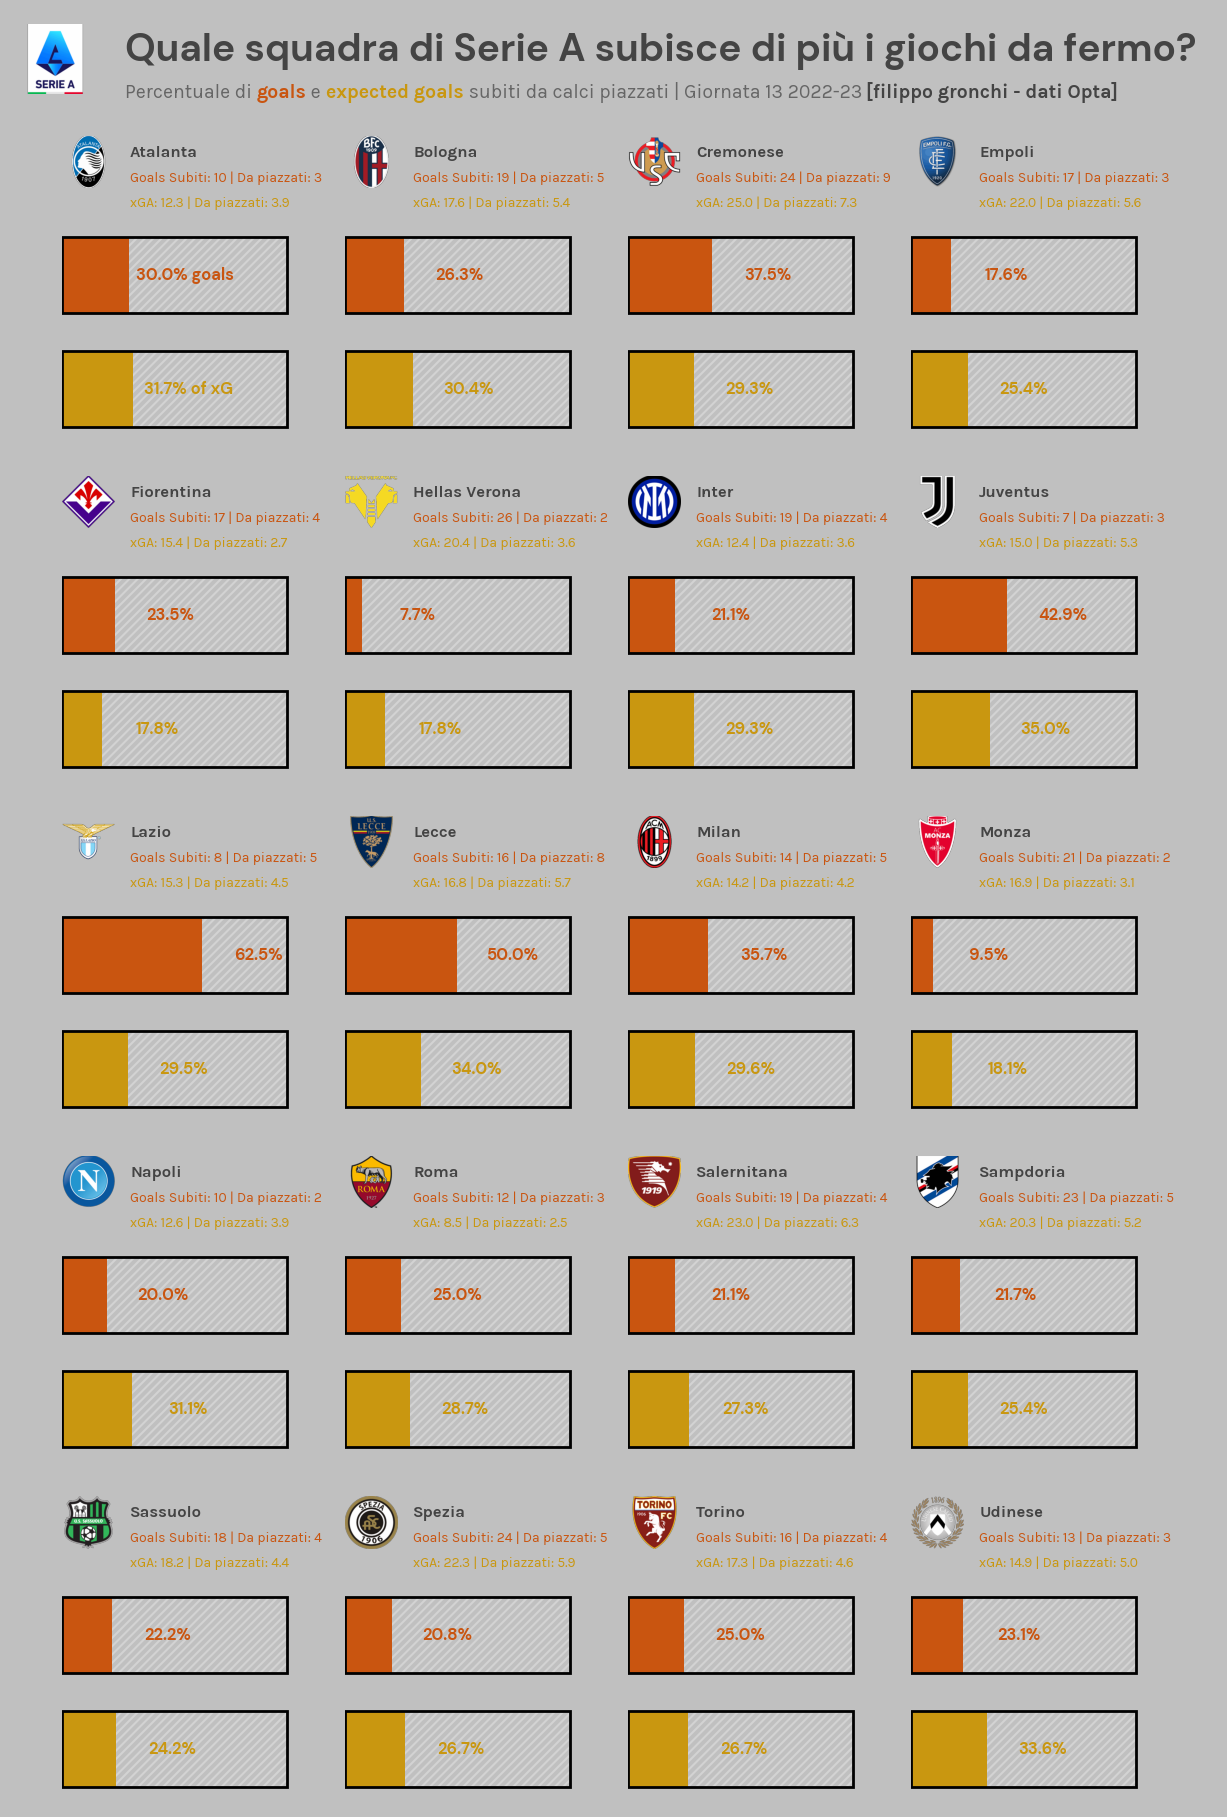

In [12]:
# Allowed Goals and xGA
def plot_battery_charta(data, team_id, ax, legend = False):
    '''
    This function plots the share of xG and goals that were created
    from set-pieces and corners in the MLS.

    Args:
        data (DataFrame): the pandas DataFrame with the data.
        team_id (int): the Fotmob team id.
        ax (object): the matplotlib axes in which to draw the plot.
    '''

    goal_share = data[data["teamId"] == team_id]["GoalSPA_share"].iloc[0]
    xg_share = data[data["teamId"] == team_id]["xGA_sp_share"].iloc[0]

    # Hatch parameters
    plt.rcParams['hatch.linewidth'] = 0.75
    plt.rcParams['hatch.color'] = "lightgrey"

    # Goal share

    if legend:
        goal_text = f"{goal_share:.1%} goals"
        xg_text = f"{xg_share:.1%} of xG"
    else:
        goal_text = f"{goal_share:.1%}"
        xg_text = f"{xg_share:.1%}"      

    height = .1

    ax.barh([1], [1], height = height, facecolor = "none", ec = "black", zorder = 3)
    ax.barh([1], [goal_share], height = height, color = "#c95510")
    ax.barh([1], [1 - goal_share], height = height, left = goal_share, facecolor = "none", hatch="////////")
    ax.annotate(
        xy = (goal_share, 1),
        xytext = (20, 0),
        textcoords = "offset points",
        text = goal_text,
        ha = "center",
        va = "center",
        size = 6,
        weight = "bold",
        family = "DM Sans",
        color = "#c95510"
    )

    ax.barh([.85], [1], height = height, facecolor = "none", ec = "black", zorder = 3)
    ax.barh([.85], [xg_share], height = height, color = "#c99710")
    ax.barh([.85], [1 - xg_share], height = height, left = xg_share, facecolor = "none", hatch="////////")
    ax.annotate(
        xy = (xg_share, .85),
        xytext = (20, 0),
        textcoords = "offset points",
        text = xg_text,
        ha = "center",
        va = "center",
        size = 6,
        weight = "bold",
        family = "DM Sans",
        color = "#c99710"
    )

    ax.set_axis_off()


# --- We do the final chart.

fig = plt.figure(figsize=(7, 11), dpi = 200, facecolor="#c0c0c0")
nrows = 10
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios = [(1/nrows)*2. if x % 2 != 0 else (1/nrows)/2. for x in range(nrows)], hspace = 0.3
)

plot_counter = 0
logo_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor = "#c0c0c0"
            )

            if row == 1 and col == 0:
                legend = True
            else:
                legend = False
            
            plot_battery_charta(data = df_finala, team_id=df_finala["teamId"].iloc[plot_counter], ax = ax, legend = legend)            

            plot_counter += 1
        
        else:
            team_id = df_finala["teamId"].iloc[logo_counter]
            team_name = df_finala["teamName"].iloc[logo_counter]
            goal_set_pieces = df_finala[df_finala["teamId"] == team_id]["GoalSPAtot"].iloc[0]
            xg_set_pieces = df_finala[df_finala["teamId"] == team_id]["xGA_sp_tot"].iloc[0]
            goals_for = df_finala[df_finala["teamId"] == team_id]["GoalATot"].iloc[0]
            xg_for = df_finala[df_finala["teamId"] == team_id]["xGATot"].iloc[0]


            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = "NW", facecolor = "#c0c0c0"
            )
            club_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/teamlogo/{team_id:.0f}.png"))
            logo_ax.imshow(club_icon)
            logo_ax.axis("off")

            # Add the team name
            ax_text(
                x = 1.3, 
                y = 0.81,
                s = f"{team_name}",
                ax = logo_ax, 
                weight = "bold", 
                font = "Karla", 
                ha = "left", 
                size = 6,
                color="#444444",
                annotationbbox_kw = {"xycoords":"axes fraction"}
            )

            # Add the subtitles for each side
            ax_text(
                x = 1.3,
                y = 0.32,
                s = f"<Goals Subiti: {goals_for} | Da piazzati: {goal_set_pieces}>\n<xGA: {xg_for:.1f} | Da piazzati: {xg_set_pieces:.1f}>",
                highlight_textprops=[
                    {"color":"#c95510"},
                    {"color":"#c99710"}
                ],
                ax = logo_ax, 
                weight = "normal", 
                font = "Karla", 
                ha = "left", 
                size = 5, 
                annotationbbox_kw = {"xycoords":"axes fraction"}
            )

            logo_counter += 1


fig_text(
    x = 0.17, y = .91, 
    s = "Quale squadra di Serie A subisce di più i giochi da fermo?",
    va = "bottom", ha = "left",
    fontsize = 14, color = "#444444", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.17, y = .895, 
    s = "Percentuale di <goals> e <expected goals> subiti da calci piazzati | Giornata 13 2022-23 <[filippo gronchi - dati Opta]>",
    highlight_textprops=[
        {"color":"#c95510", "weight":"bold"},
        {"color":"#c99710", "weight":"bold"},
        {"color":"#444444", "weight":"bold"}
    ],
	va = "bottom", ha = "left",
	fontsize = 7, color = "#666666", font = "Karla"
)

# # ---- The League's logo
league_icon = Image.open(urllib.request.urlopen(f"https://images.fotmob.com/image_resources/logo/leaguelogo/55.png"))
league_ax = fig.add_axes([0.095, 0.89, 0.05, 0.05], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")

plt.savefig(
	"../figures/SerieA_22_23_set_pieceA.png",
	dpi = 500,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)


C:\Users\fgron\AppData\Local\Temp\ipykernel_20452\2994857462.py:7: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  return OffsetImage(plt.imread(path), zoom=.09, alpha = 1)


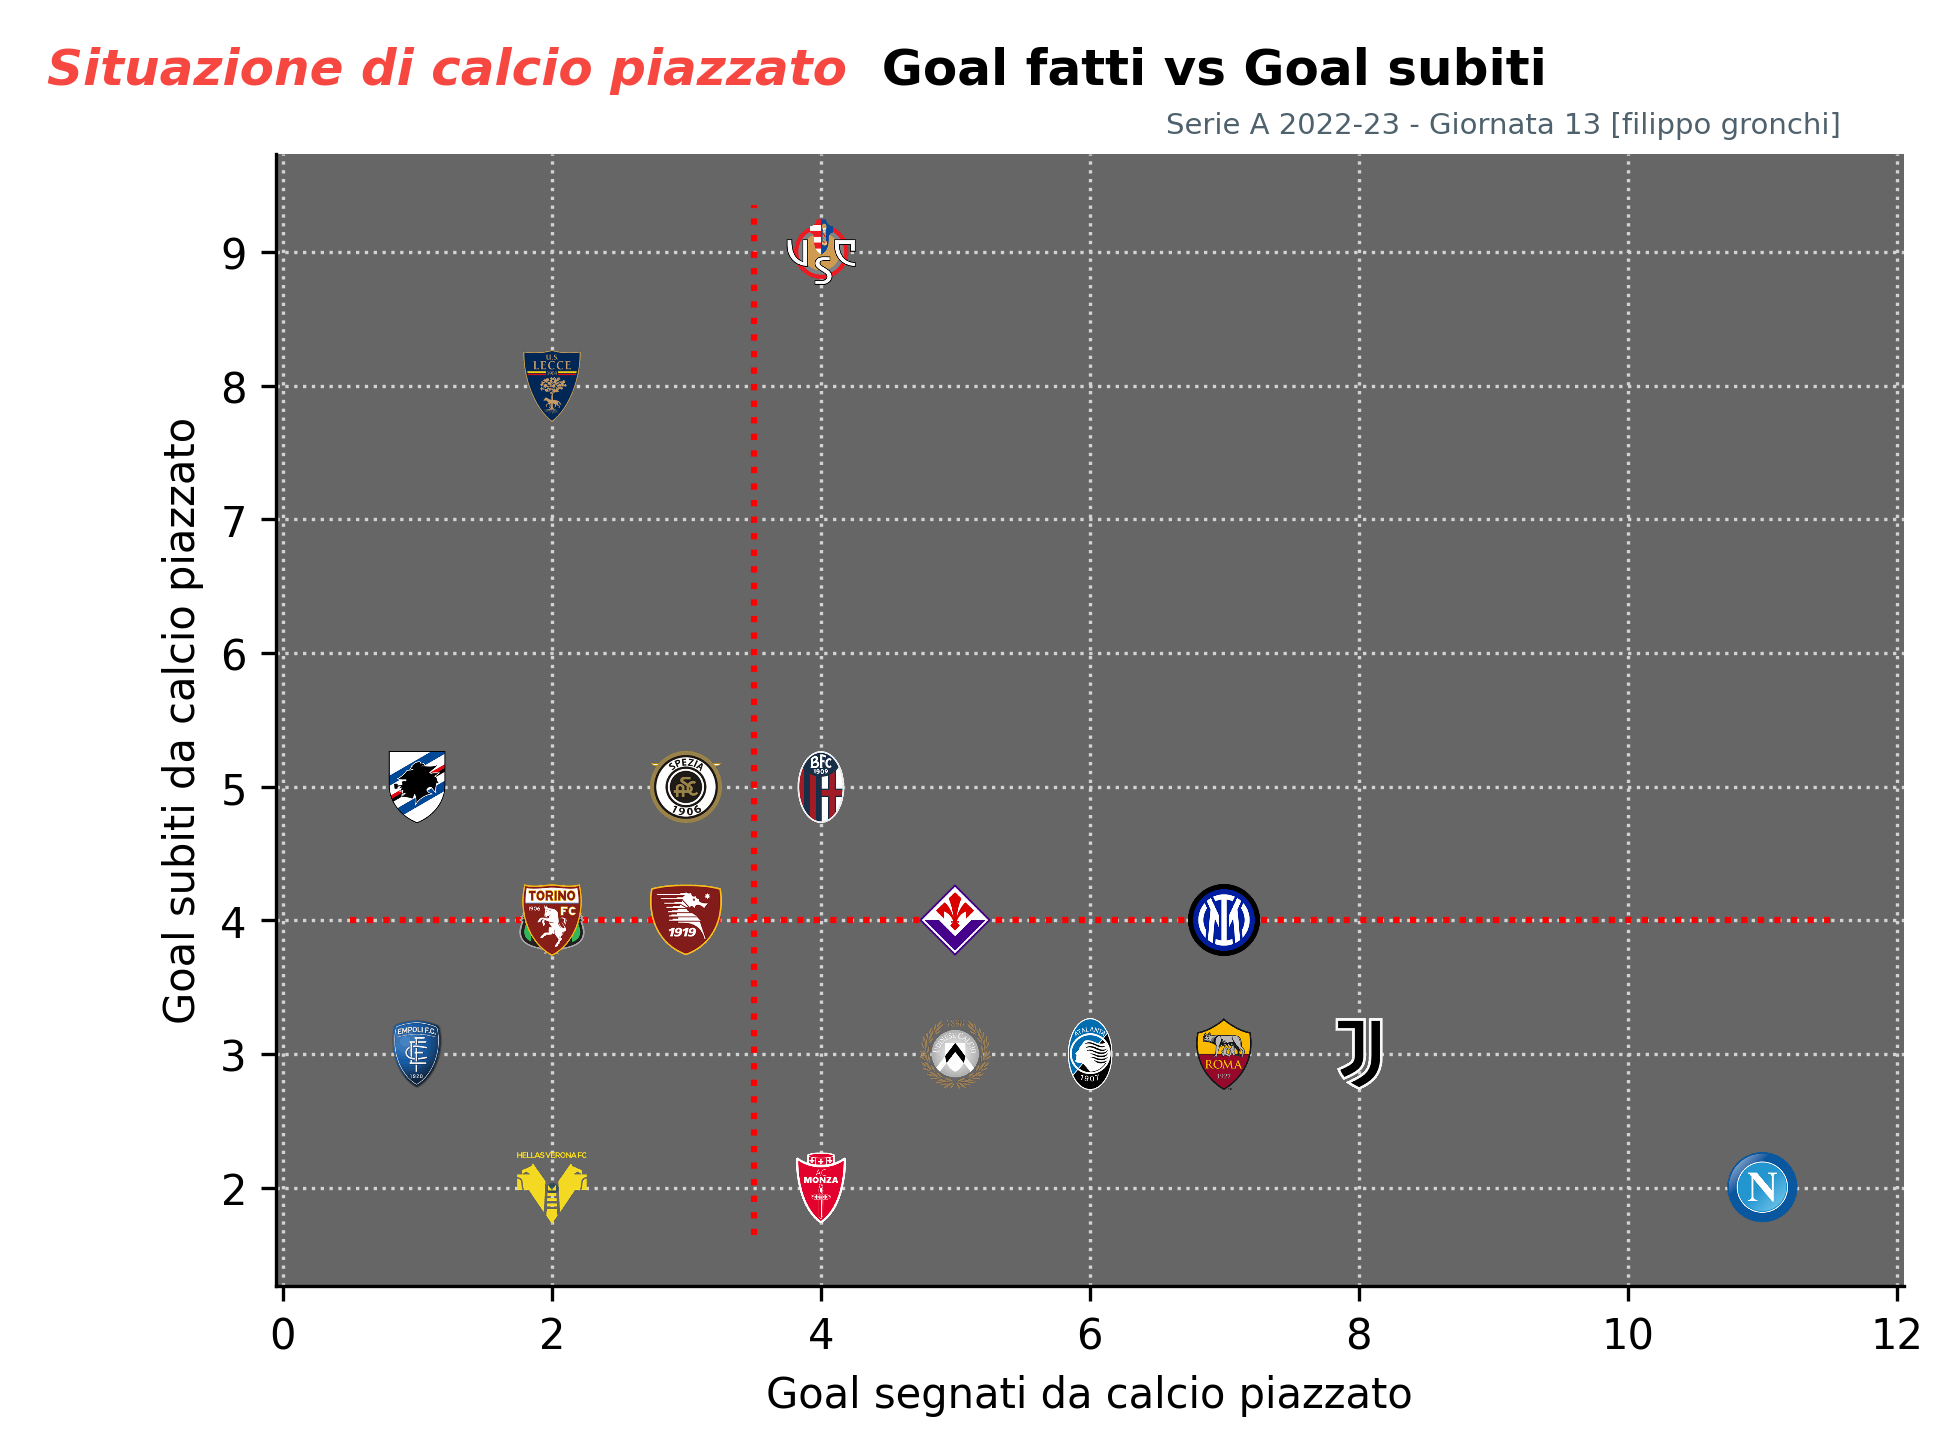

In [13]:
# Scored Goals and xG Scatterplot
df_finalTOT = pd.merge(df_final, df_finala, on=['teamName','teamId'], how='inner')
df_finalTOT = df_finalTOT[['teamName', 'teamId', 'GoalSPtot', 'GoalSPAtot', 'xG_sp_tot', 'xGA_sp_tot' ]]

dataset = df_finalTOT
def getImage(path):
    return OffsetImage(plt.imread(path), zoom=.09, alpha = 1)

fig = plt.figure(figsize = (7,5), dpi = 300)
ax = plt.subplot(facecolor = "#666666")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(
    dataset["GoalSPtot"], 
    dataset["GoalSPAtot"], 
    s = 3, 
    alpha = 0.75, 
    color = "#264653",
    zorder = 3
)
ax.plot(
    [dataset["GoalSPtot"].median(), dataset["GoalSPtot"].median()],
    [ax.get_ylim()[0], ax.get_ylim()[1]], 
    ls = ":",
    color = "red",
    zorder = 2
)
ax.plot(
    [ax.get_xlim()[0], ax.get_xlim()[1]],
    [dataset["GoalSPAtot"].median(), dataset["GoalSPAtot"].median()], 
    ls = ":",
    color = "red",
    zorder = 2
)
ax.grid(True, ls = ":", color = "lightgray")

#squadra = "FIO"
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, name in enumerate(dataset["teamName"]):
    X = dataset["GoalSPtot"].iloc[index]
    Y = dataset["GoalSPAtot"].iloc[index]
    y_pos = -9
    x_pos = 0
    path = fotmob_url + str(dataset["teamId"].iloc[index]) + ".png"
    frame = False
    #if (name == squadra):
    #    frame = True
    ab = AnnotationBbox(getImage(path), (X, Y), frameon=frame)
    ax.add_artist(ab)

ax.set_ylabel("Goal subiti da calcio piazzato")
ax.set_xlabel("Goal segnati da calcio piazzato")

fig_text(
        x = 0.73, y = 0.92, 
        s = "<Situazione di calcio piazzato>  Goal fatti vs Goal subiti",
        highlight_textprops=[{"color":"#F64740", "style":"italic"}],
        va = "bottom", ha = "right",
        fontsize = 12, color = "black", weight = "bold"
)

subTitle =  "Serie A 2022-23 - Giornata 13 [filippo gronchi]"
fig_text(
	    x = 0.87, y = .89, 
        s = subTitle,
	    va = "bottom", ha = "right",
	    fontsize = 7, color = "#4E616C",
)

filename = "../figures/giochi_da_fermo_fatti_subiti_SerieA_22_23_12.png"
plt.savefig(
	    filename,
	    dpi = 600,
	    facecolor = "none",
	    bbox_inches="tight",
        edgecolor="none",
	    transparent = False
    )

C:\Users\fgron\AppData\Local\Temp\ipykernel_20452\1555992664.py:5: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  return OffsetImage(plt.imread(path), zoom=.09, alpha = 1)


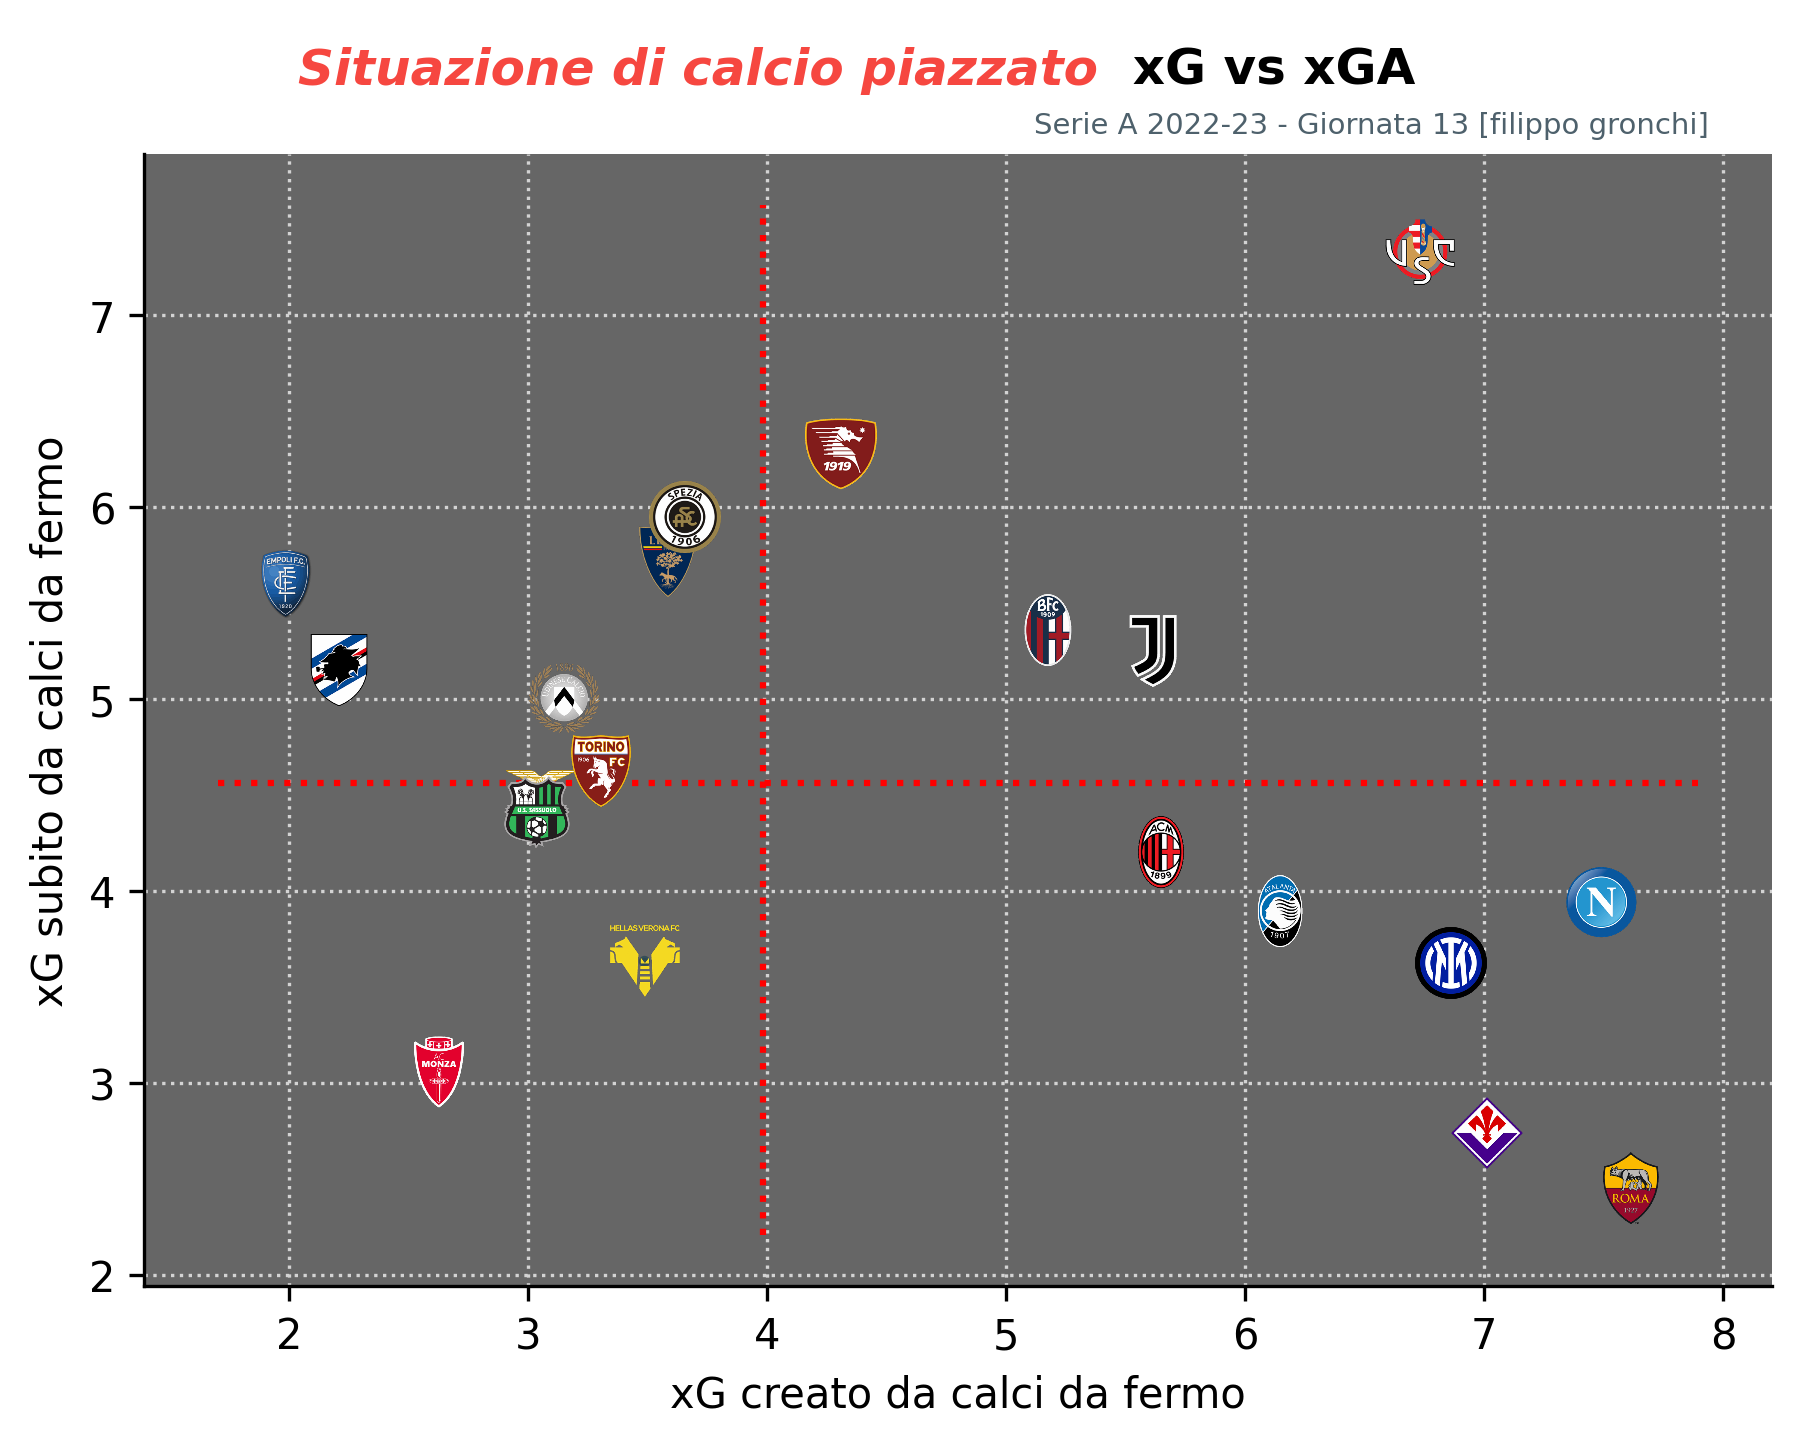

In [14]:
# Allowed Goals and xGA Scatterplot

dataset = df_finalTOT
def getImage(path):
    return OffsetImage(plt.imread(path), zoom=.09, alpha = 1)

fig = plt.figure(figsize = (7,5), dpi = 300)
ax = plt.subplot(facecolor = "#666666")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(
    dataset["xG_sp_tot"], 
    dataset["xGA_sp_tot"], 
    s = 3, 
    alpha = 0.75, 
    color = "#264653",
    zorder = 3
)
ax.plot(
    [dataset["xG_sp_tot"].median(), dataset["xG_sp_tot"].median()],
    [ax.get_ylim()[0], ax.get_ylim()[1]], 
    ls = ":",
    color = "red",
    zorder = 2
)
ax.plot(
    [ax.get_xlim()[0], ax.get_xlim()[1]],
    [dataset["xGA_sp_tot"].median(), dataset["xGA_sp_tot"].median()], 
    ls = ":",
    color = "red",
    zorder = 2
)
ax.grid(True, ls = ":", color = "lightgray")

#squadra = "FIO"
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, name in enumerate(dataset["teamName"]):
    X = dataset["xG_sp_tot"].iloc[index]
    Y = dataset["xGA_sp_tot"].iloc[index]
    y_pos = -9
    x_pos = 0
    path = fotmob_url + str(dataset["teamId"].iloc[index]) + ".png"
    frame = False
    #if (name == squadra):
    #    frame = True
    ab = AnnotationBbox(getImage(path), (X, Y), frameon=frame)
    ax.add_artist(ab)

ax.set_ylabel("xG subito da calci da fermo")
ax.set_xlabel("xG creato da calci da fermo")

fig_text(
        x = 0.73, y = 0.92, 
        s = "<Situazione di calcio piazzato>  xG vs xGA",
        highlight_textprops=[{"color":"#F64740", "style":"italic"}],
        va = "bottom", ha = "right",
        fontsize = 12, color = "black", weight = "bold"
)

subTitle =  "Serie A 2022-23 - Giornata 13 [filippo gronchi]"
fig_text(
	    x = 0.87, y = .89, 
        s = subTitle,
	    va = "bottom", ha = "right",
	    fontsize = 7, color = "#4E616C",
)

filename = "../figures/giochi_da_fermo_xG_xGA_SerieA_22_23_12.png"
plt.savefig(
	    filename,
	    dpi = 600,
	    facecolor = "none",
	    bbox_inches="tight",
        edgecolor="none",
	    transparent = False
    )